In [33]:
import GEOparse
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re

# GSE48452

This notebook provides a brief exploration of the [GSE48452 dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE48452). Our goal is to extract (1) gene expression intensity values, (2) the condition of each patient, and (3) a symbol for each gene in the dataset.

We start by loading the dataset with GEOparse and creating a cycling iterator to go through all GEO samples.

In [53]:
gse = GEOparse.get_GEO(geo="GSE48452", destdir='../data', silent=True)
gsm_cycler = itertools.cycle(gse.gsms.items())

Here, we visualize single GEO samples, each represented by a DataFrame containing probes as rows and a `VALUE` column with the gene expression intensity values.

In [54]:
gsm_name, gsm = next(gsm_cycler)
table = gsm.table
print(table['VALUE'].describe())
table.head()

count    33297.000000
mean         5.155996
std          2.375948
min          0.808466
25%          3.226511
50%          4.845805
75%          6.762773
max         13.633922
Name: VALUE, dtype: float64


,ID_REF,VALUE
0,7892501,3.172159
1,7892502,3.108343
2,7892503,2.509425
3,7892504,7.231928
4,7892505,1.576372


Each GEO sample contains relevant metadata.

In [4]:
gsm_name, gsm = next(gsm_cycler)

for k, v in gsm.metadata.items():
    print(f'{k}: {v}')

title: ['liver, C, A1359-02']
geo_accession: ['GSM1178971']
status: ['Public on Aug 08 2013']
submission_date: ['Jul 01 2013']
last_update_date: ['Aug 08 2013']
type: ['RNA']
channel_count: ['1']
source_name_ch1: ['Control']
organism_ch1: ['Homo sapiens']
taxid_ch1: ['9606']
characteristics_ch1: ['tissue type: liver biopsy', 'group: Control', 'fat: 3', 'inflammation: 1', 'other_id: NA', 'bariatric surgery: NA', 'Sex: female', 'age: 51', 'bmi: 23.6', 'nas: 1', 'fibrosis: NA', 'lar: 0', 'delta lar: NA', 'delta leptin: NA', 'leptin: 0', 'adiponectin: 12.43', 'delta adipo: NA']
treatment_protocol_ch1: ['not applicable']
growth_protocol_ch1: ['liver biopsy']
molecule_ch1: ['total RNA']
extract_protocol_ch1: ['For homogenisation of five to ten milligram frozen tissue and subsequent nucleic acid isolation, tubes with 1,4\xa0mm ceramic beads (Precellys, Villeurbanne, France) and the AllPrep DNA/RNA Mini Kit (QIAGEN, Hilden, Germany) were used.']
label_ch1: ['biotin']
label_protocol_ch1: ['acco

We are interested in knowing the condition of each patient; hence, we extract it from the `characteristics_ch1` value. The dataset contains 14 control patients, 27 healthy patients with obsity, 14 patients with steatosis and 18 patients with NASH. For integration with other datasets, we map these names to _control_, _healthy obese_, _NAFL_ and _NASH_.

In [5]:
geo_accessions = [gsm.metadata['geo_accession'][0] for _, gsm in gse.gsms.items()]
stages = [next((item.split(": ")[1] for item in gsm.metadata['characteristics_ch1'] if item.startswith("group:")), None) for _, gsm in gse.gsms.items()]
print('Original conditions: ', np.unique(stages))
mapping = {'Control': 'control', 'Healthy obese': 'healthy obese', 'Steatosis': 'NAFL', 'Nash': 'NASH'}
stages = [mapping[stage] for stage in stages]
values, counts = np.unique(stages, return_counts=True)

print('Conditions:')
for stage, count in zip(values, counts):
    print(f'- {stage}: {count}')

Original conditions:  ['Control' 'Healthy obese' 'Nash' 'Steatosis']
Conditions:
- NAFL: 14
- NASH: 18
- control: 14
- healthy obese: 27


Now we gather all samples in a single DataFrame.

In [6]:
data = []
for i, (gsm_name, gsm) in enumerate(gse.gsms.items()):
    table = gsm.table
    table.columns = ['ID_REF', gsm_name]
    data.append(table if i == 0 else table[gsm_name])
data = pd.concat(data, axis=1)
data.set_index('ID_REF', inplace=True)

data.head()

,GSM1178970,GSM1178971,GSM1178972,GSM1178973,GSM1178974,GSM1178975,GSM1178976,GSM1178977,GSM1178978,GSM1178979,...,GSM1179033,GSM1179034,GSM1179035,GSM1179036,GSM1179037,GSM1179038,GSM1179039,GSM1179040,GSM1179041,GSM1179042
ID_REF,,,,,,,,,,,,,,,,,,,,,
7892501,3.172159,3.322146,4.131542,2.225883,2.436203,3.159068,3.937725,4.715104,3.078688,1.546285,...,4.151240,2.087608,2.916155,2.090180,1.907727,2.296681,2.292631,1.833231,2.077573,2.074308
7892502,3.108343,3.494193,2.857529,3.483998,2.838848,3.309446,2.727647,2.906121,3.538057,3.094374,...,3.336864,4.290730,2.888513,3.273764,3.141447,3.227904,4.336199,3.119768,2.213164,2.822951
7892503,2.509425,2.144811,2.968757,3.654358,4.317170,3.009281,2.975471,2.951081,3.911673,3.504420,...,2.750290,3.253756,2.727128,2.758524,2.774781,3.184269,2.870974,2.920791,3.031302,3.498532
7892504,7.231928,7.578190,7.283043,7.377781,6.465647,7.909563,6.959765,6.944438,7.696474,6.896190,...,7.132856,7.246651,6.810757,6.913429,6.798151,6.952473,7.430448,7.953143,6.300479,6.710218
7892505,1.576372,2.479748,1.982190,1.713928,2.154730,2.477483,1.488781,1.766051,2.893852,2.278938,...,1.729462,2.763826,2.340915,2.231745,2.218666,1.728845,1.762520,1.628453,1.593919,3.355724


Let's plot the distribution of intensities. It seems there was some normalization done on this data. Gene expression values per sample seem to have the same scale.

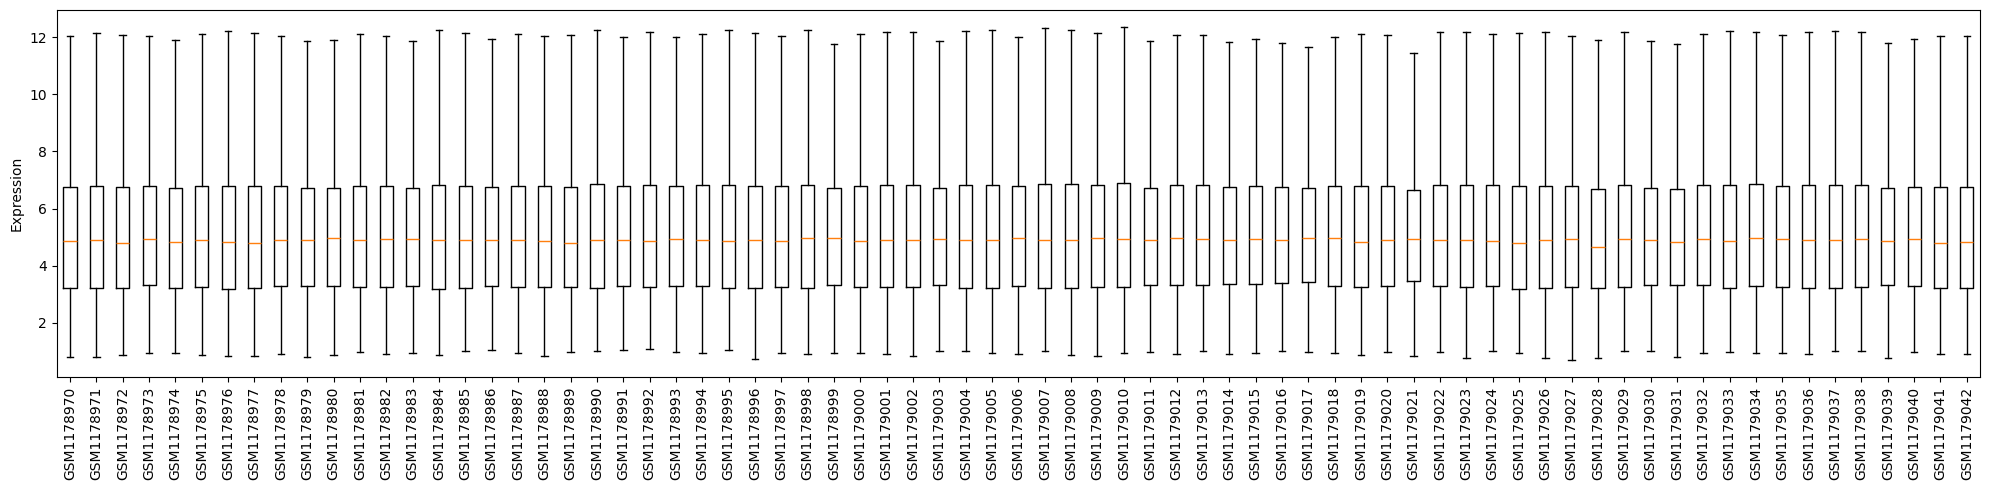

In [7]:
values = data.values.astype(float)

plt.figure(figsize=(20, 5))
plt.boxplot(values, tick_labels=data.columns, showfliers=False)
plt.xticks(rotation=90)
plt.ylabel('Expression')
plt.tight_layout()
plt.show()

Finally, we look at the platform data to search for gene symbols. Our GSE object (naturally) has one single platform.

In [8]:
gse.gpls.items()

dict_items([('GPL11532', <d: GPL11532>)])

The platform metadata contains relevant information, like the microarray's name, GEO accession ID, and number of probes. The table data contains information about each probe.

In [9]:
gpl = list(gse.gpls.values())[0]

print('Title: ', gpl.metadata['title'][0])
print('GEO Accession: ', gpl.metadata['geo_accession'][0])
print('Number of probes: ', gpl.metadata['data_row_count'][0])

gpl_table = gpl.table
gpl_table.head(3)

Title:  [HuGene-1_1-st] Affymetrix Human Gene 1.1 ST Array [transcript (gene) version]
GEO Accession:  GPL11532
Number of probes:  33297


,ID,GB_LIST,SPOT_ID,seqname,RANGE_GB,RANGE_STRAND,RANGE_START,RANGE_STOP,total_probes,gene_assignment,mrna_assignment,category
0,7896736,NaN,chr1:53049-54936,chr1,NC_000001.10,+,53049,54936,7,---,---,---
1,7896738,NaN,chr1:63015-63887,chr1,NC_000001.10,+,63015,63887,31,---,ENST00000328113 // ENSEMBL // cdna:pseudogene ...,main
2,7896740,"NM_001005240,NM_001004195,NM_001005484,BC13684...",chr1:69091-70008,chr1,NC_000001.10,+,69091,70008,24,"NM_001005240 // OR4F17 // olfactory receptor, ...",NM_001005240 // RefSeq // Homo sapiens olfacto...,main


Here, we are interested in gene symbols. These are embedded in the `gene_assignment` column, so we parse these string values. We retain 22,037 probes with 20,694 unique genes.

In [52]:
# We drop the probes that do not have a gene symbol
gb_list = gpl_table[['GB_LIST', 'gene_assignment']].dropna()
gb_list.drop(gb_list[gb_list['gene_assignment'] == '---'].index, inplace=True)

symbols = []
symbols_unique = set()
for gbs, assignment in tqdm(gb_list.values, total=len(gb_list)):
    gbs = gbs.split(',')
    parsed = []
    for gb in gbs:
        try:
            parsed.append(re.search(rf"{gb} // (\w+) //", assignment).group(1))
        except:
            pass
    parsed = list(set(parsed))
    symbols.append(parsed)
    symbols_unique.update(parsed)

print(f'Number of clean probes: {len(symbols)}')
print(f'Number of unique genes: {len(symbols_unique)}')
print(f'Example genes: {np.random.choice(list(symbols_unique), 5)}')

  0%|          | 0/22037 [00:00<?, ?it/s]

Number of clean probes: 22037
Number of unique genes: 20694
Example genes: ['RNF214' 'C20orf4' 'AGAP10' 'CDK11A' 'TXLNB']
